In [1]:
import os
import argparse
from tqdm import tqdm
import cv2
import torch
from torch import nn

from dataset import get_loader
from models.GCoNet_plus import GCoNet_plus
from util import save_tensor_img
from config import Config
import matplotlib.pyplot as plt

e:\Miniconda\envs\cv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Args():
    def __init__(self):
        self.size = 256
        self.ckpt = './ckpt/29_ep312.pth'


args = Args()

In [3]:
config = Config()

device = torch.device("cpu")
model = GCoNet_plus()
model = model.to(device)
print('Testing with model {}'.format(args.ckpt))
gconet_dict = torch.load(args.ckpt, map_location='cpu')

model.to(device)
model.load_state_dict(gconet_dict)

model.eval()
print()

e:\Miniconda\envs\cv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Miniconda\envs\cv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing with model ./ckpt/29_ep312.pth



In [4]:
# root_dir
    # testset
        # images
        # gts
root_dir = 'test_data_vis'
testset = 'CoCA_part'
test_img_path = os.path.join(root_dir, 'images', testset)
test_gt_path = os.path.join(root_dir, 'gts', testset)
saved_root = os.path.join(root_dir, 'fpns', testset)
test_loader = get_loader(test_img_path, test_gt_path, args.size, 1, istrain=False, shuffle=False, num_workers=0, pin=True)

torch.Size([32, 32])


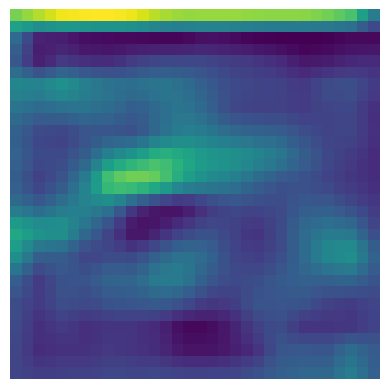

torch.Size([64, 64])


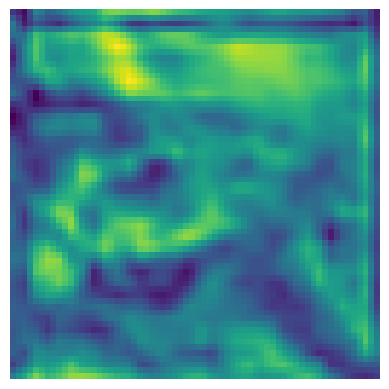

torch.Size([128, 128])


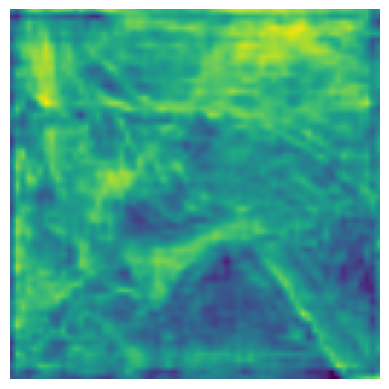

torch.Size([256, 256])


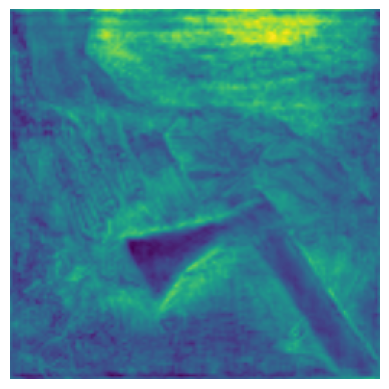

torch.Size([256, 256])


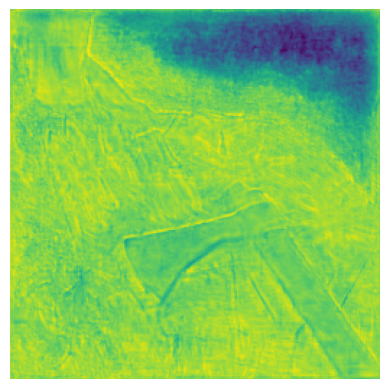

torch.Size([256, 256])


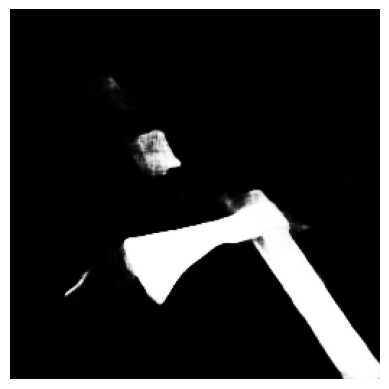

In [7]:
for idx_group, batch in enumerate(test_loader):
    inputs = batch[0].to(device).squeeze(0)
    gts = batch[1].to(device).squeeze(0)
    subpaths = batch[2]
    ori_sizes = batch[3]
    with torch.no_grad():
        features_pred = model(inputs, vis='FPN')[-6:]

    os.path.join(saved_root, subpaths[0][0].split(os.sep)[0])
    scaled_preds = features_pred[-1]

    idx_image = 0   # Choose the idx_image-th image in the given group to show
    for idx_image, sub_path in enumerate(subpaths):
        map_save_dir = os.path.join(saved_root, sub_path[0].split(os.sep)[0])
        os.makedirs(map_save_dir, exist_ok=True)
        for idx_tsr, tsr in enumerate(features_pred):
            tsr = torch.sigmoid(torch.mean(tsr[idx_image], dim=0))
            print(tsr.shape)
            plt.imshow(tsr, cmap='viridis' if idx_tsr < len(features_pred) - 1 else 'gray')
            plt.axis('off')
            plt.savefig(os.path.join(map_save_dir, '{}_fpn-{}.png'.format(sub_path[0].split(os.sep)[1], idx_tsr)), bbox_inches='tight')
            plt.show()